## **Import the required libraries**


In [1]:
!pip install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# Note: If your environment doesn't support "!mamba install", use "!pip install"


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y


In [2]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline


# Module 1: Importing Data Sets


In [4]:
# prompt: import kaggle housing dataset

!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/harrywang/housing")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: cwelbeck@gmail.com
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/harrywang/housing


100%|██████████| 400k/400k [00:00<00:00, 137MB/s]

In [5]:
# Display the first 5 rows

filepath='housing/housing.csv'
df = pd.read_csv(filepath)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


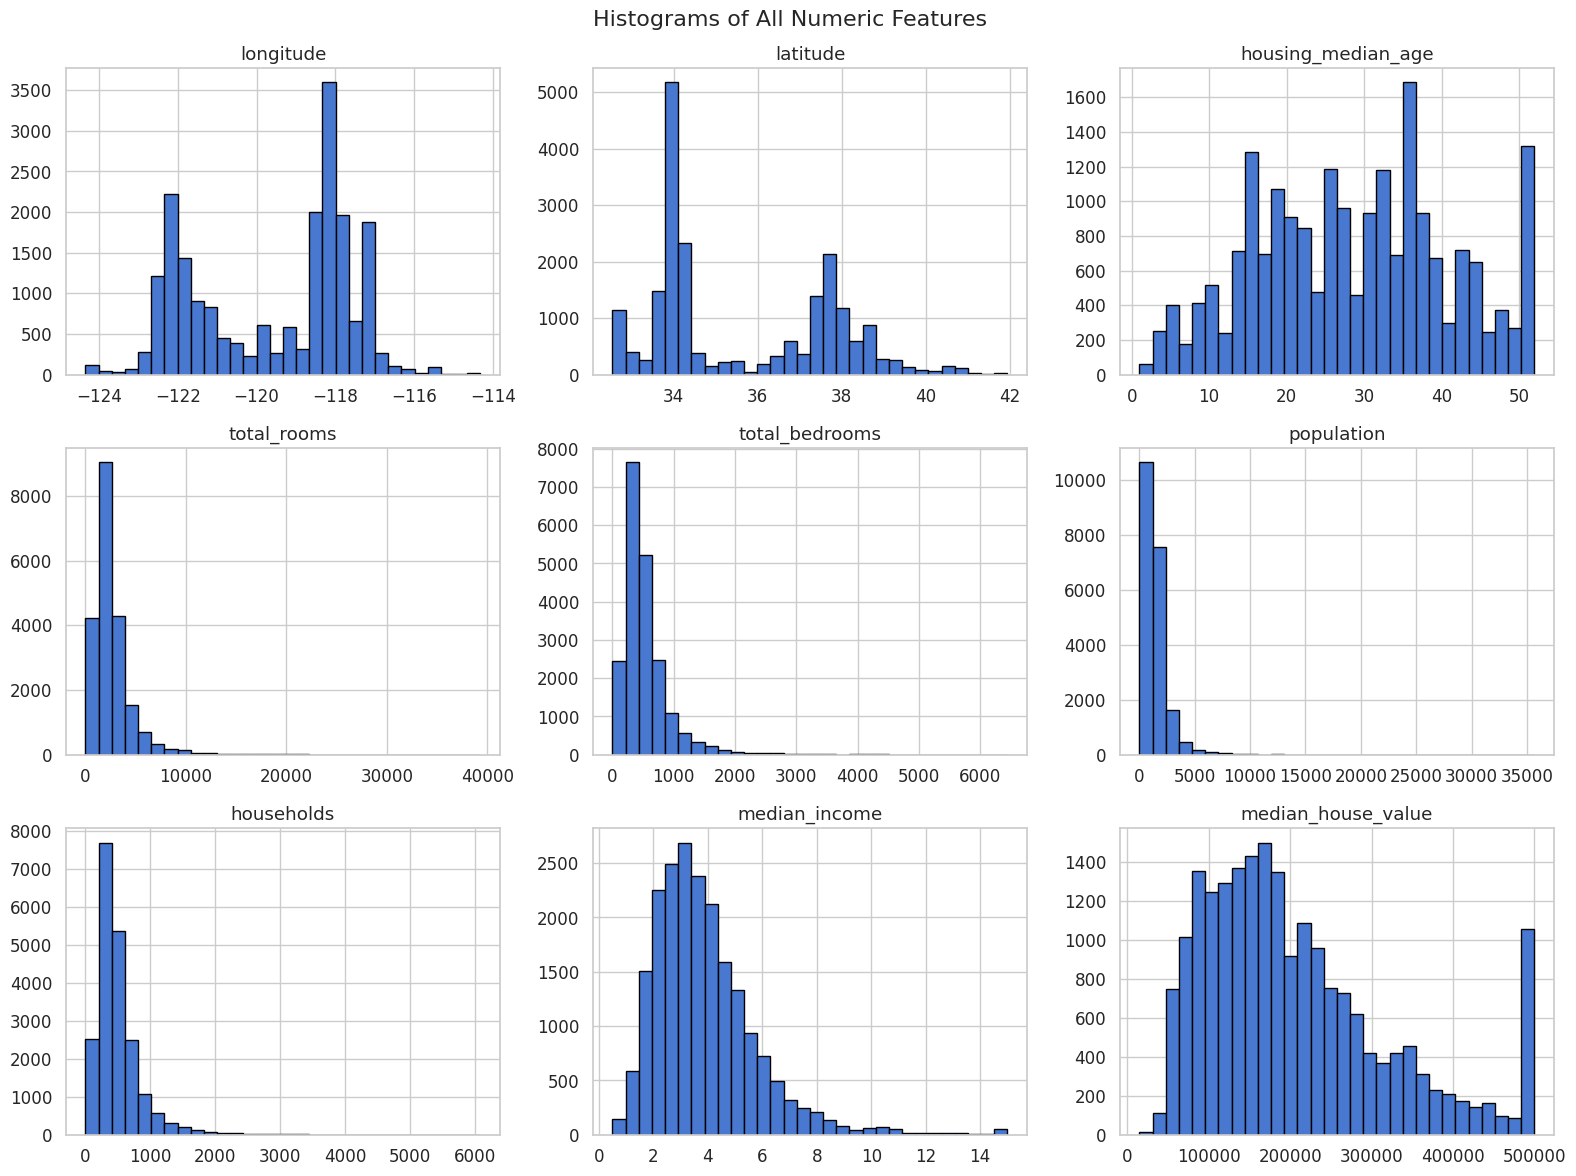

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
#df = pd.read_csv('housing.csv')

# Set plot style
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

# Create output directory if saving (optional)
# import os; os.makedirs("plots", exist_ok=True)

# 1. Histograms for all numeric features
df.hist(bins=30, figsize=(16, 12), edgecolor='black')
plt.suptitle('Histograms of All Numeric Features', fontsize=16)
plt.tight_layout()
plt.show()


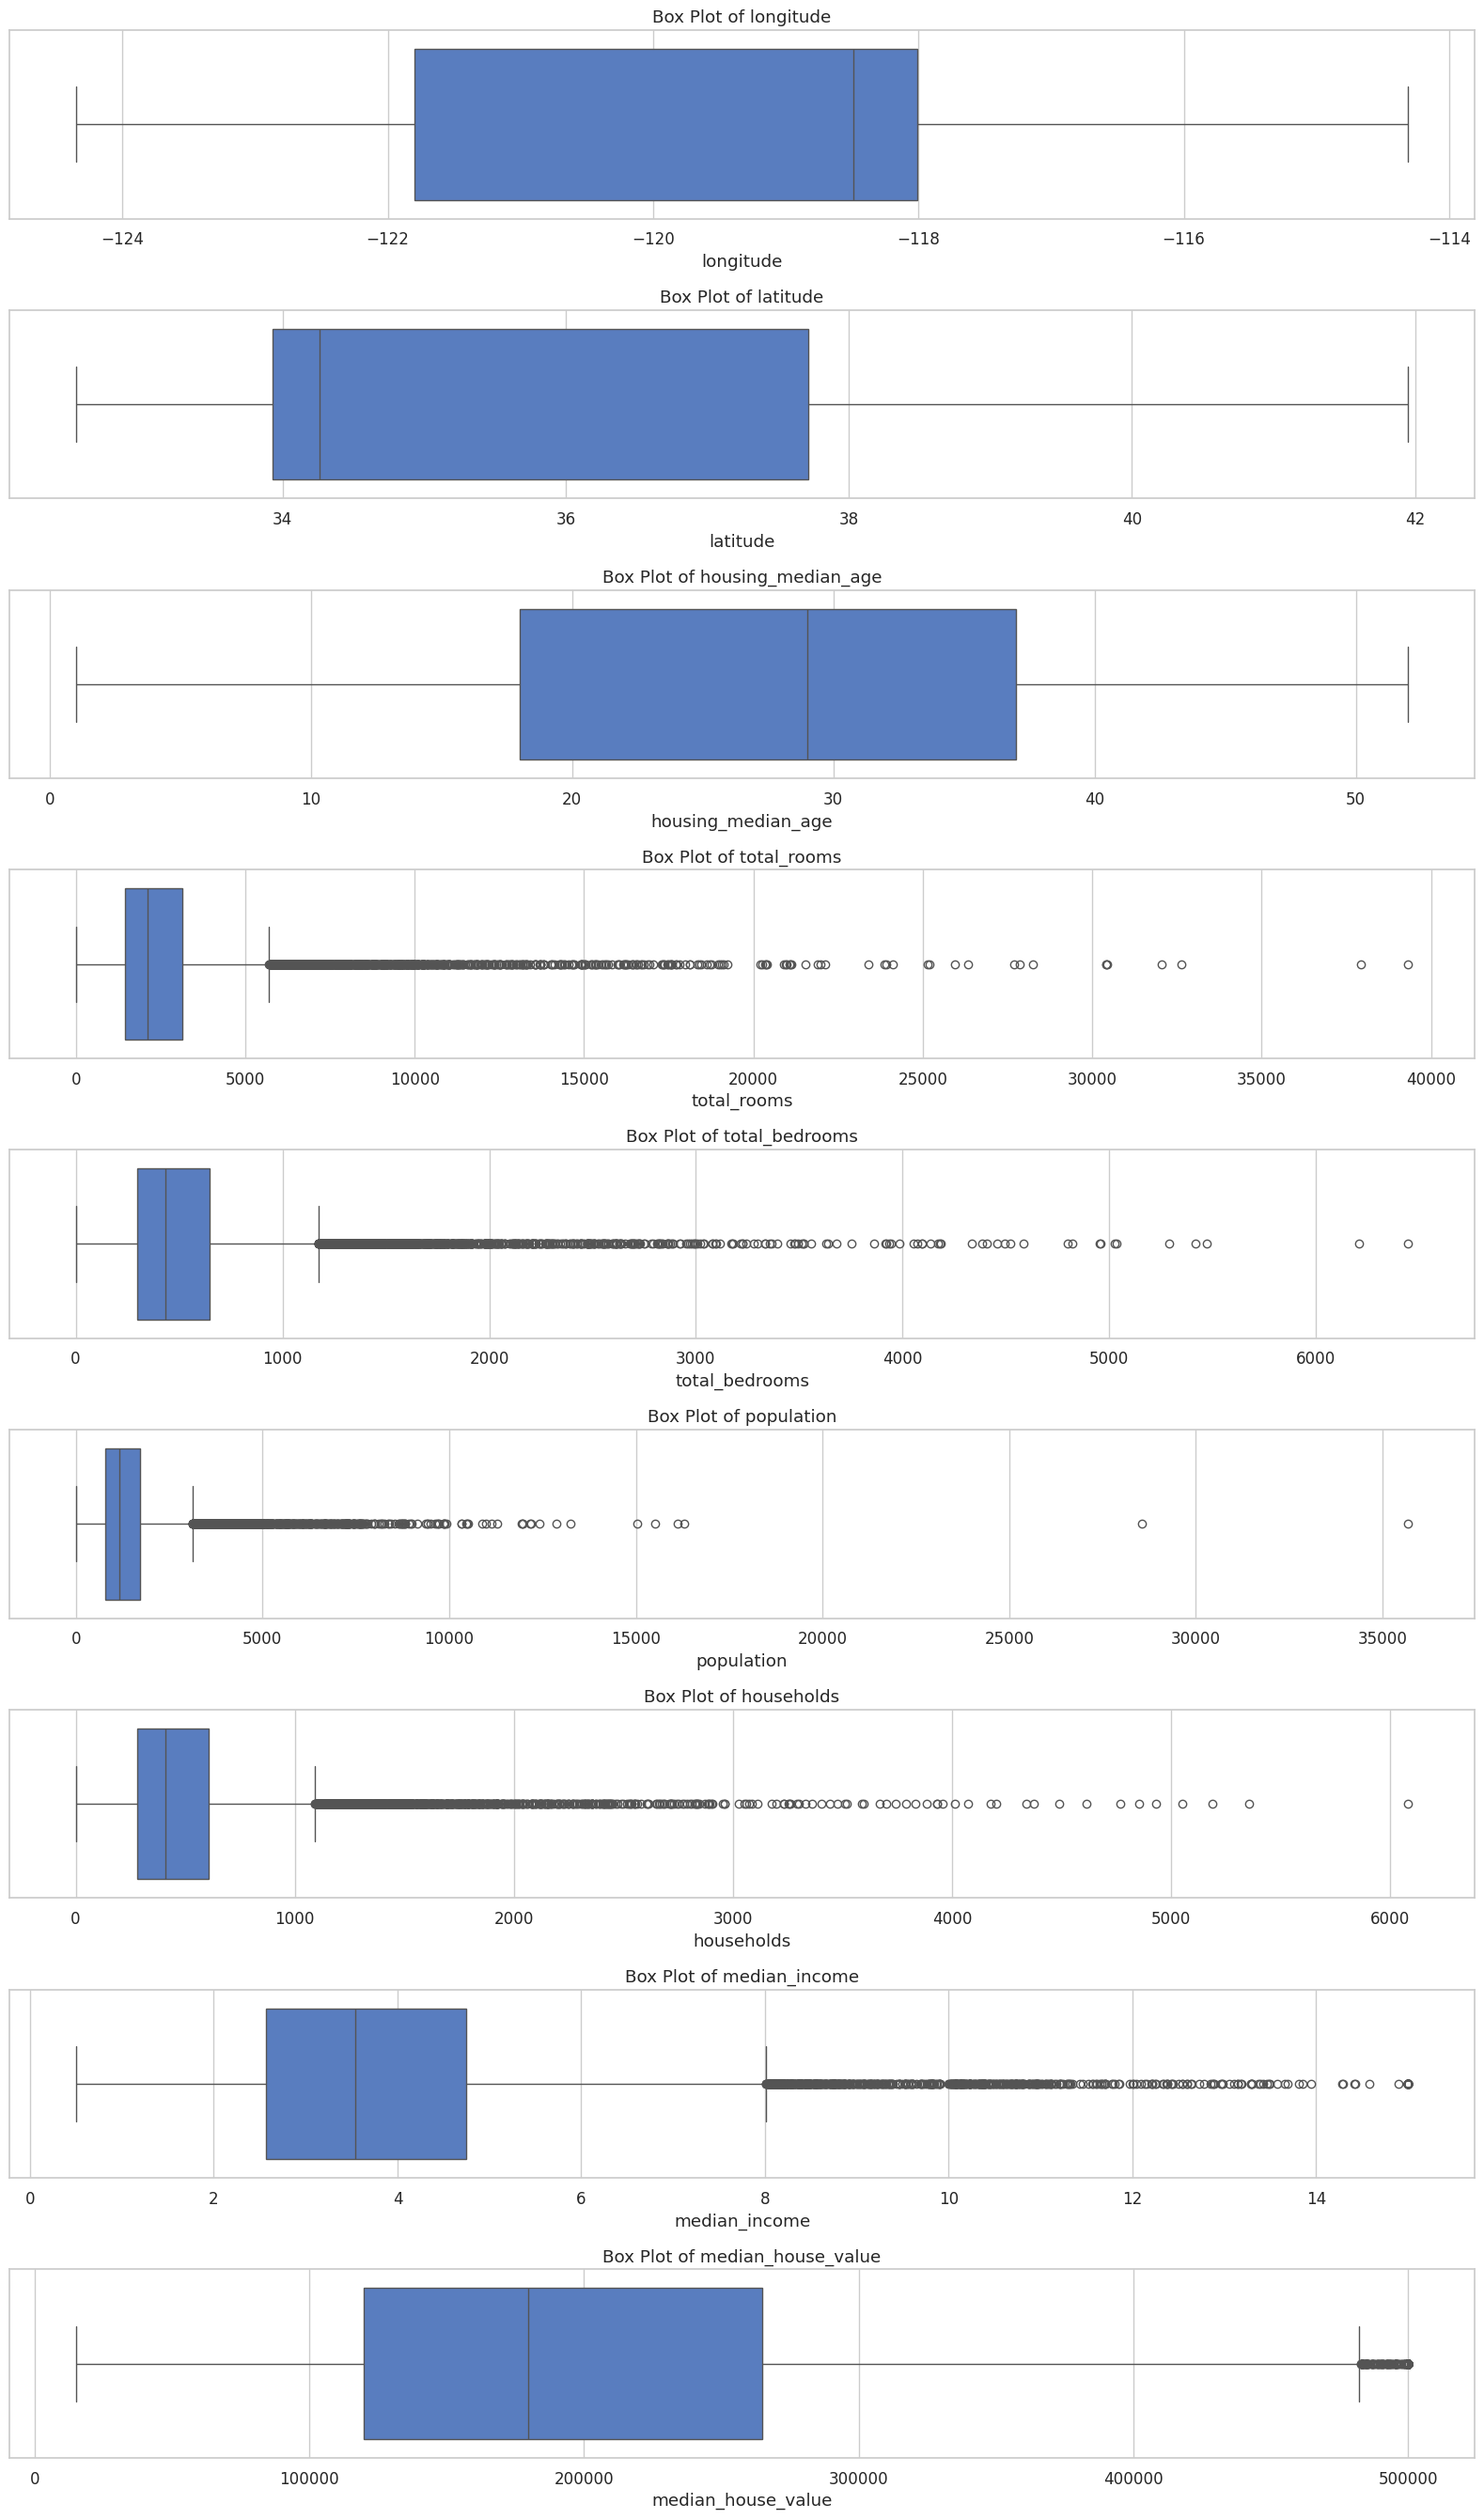

In [7]:
# Box plots for outlier detection
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(16, len(numeric_cols)*3))
for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols), 1, i+1)
    sns.boxplot(data=df, x=col)
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()


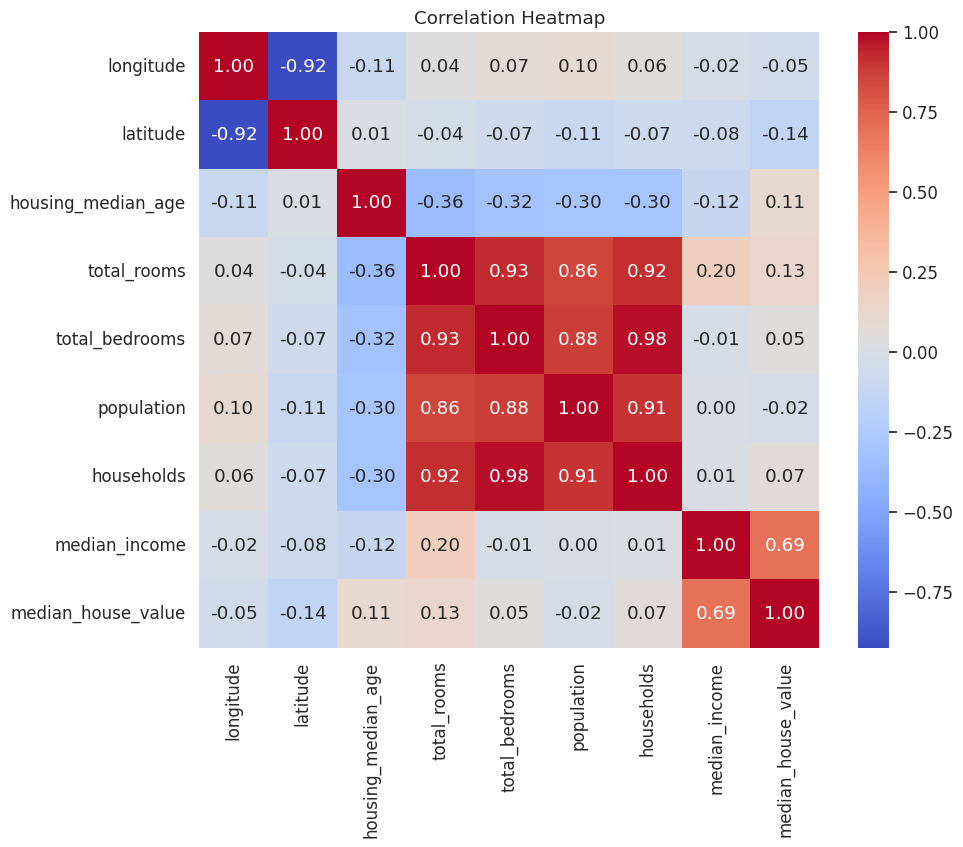

In [8]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


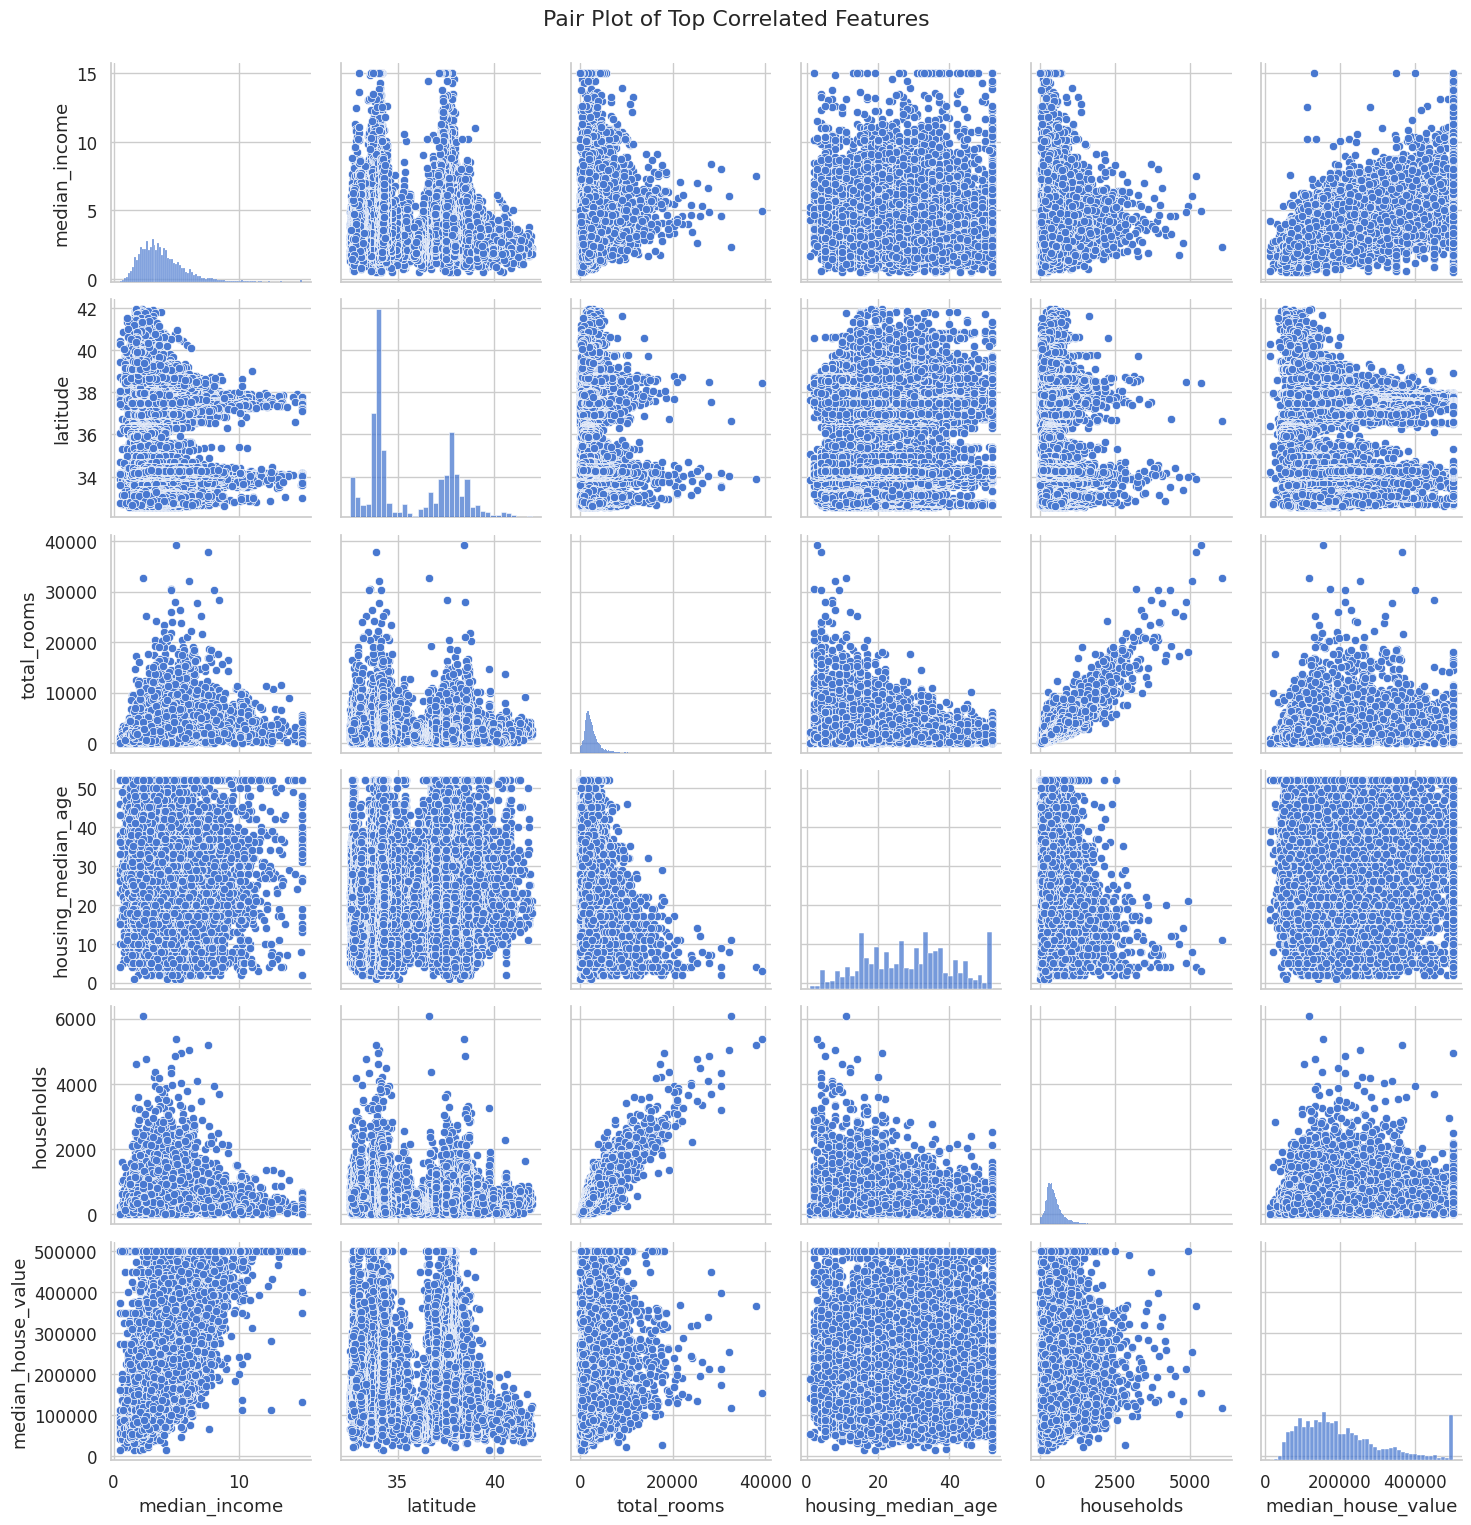

In [9]:
# Pair plot (subset of top correlated features)
top_corr_features = corr_matrix['median_house_value'].abs().sort_values(ascending=False).index[1:6]
sns.pairplot(df[top_corr_features.to_list() + ['median_house_value']])
plt.suptitle('Pair Plot of Top Correlated Features', y=1.02)
plt.show()


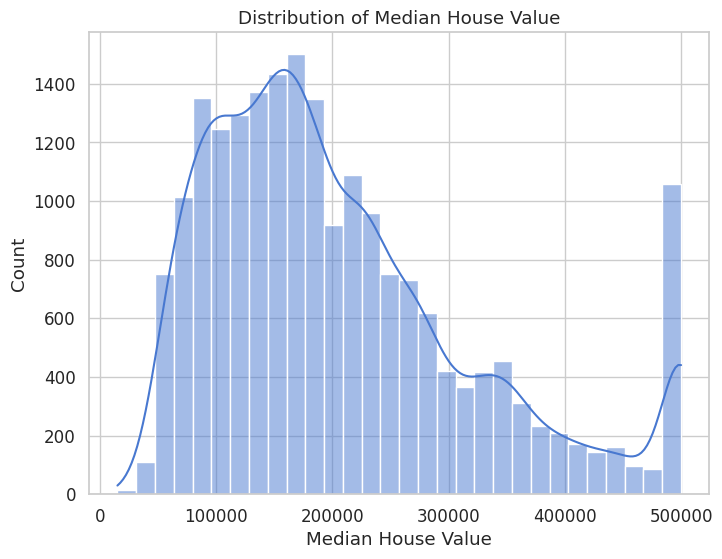

In [10]:
# Target variable distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['median_house_value'], bins=30, kde=True)
plt.title('Distribution of Median House Value')
plt.xlabel('Median House Value')
plt.ylabel('Count')
plt.show()


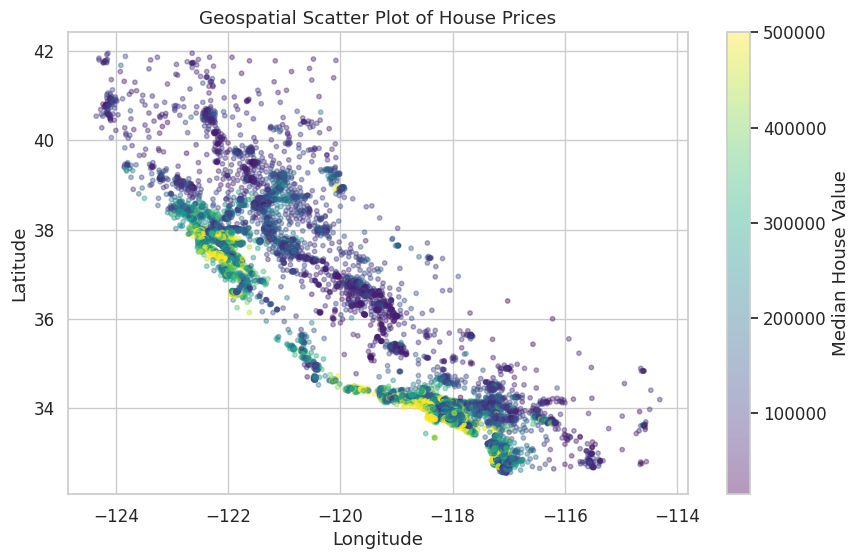

In [11]:
# Geospatial scatter plot (if latitude & longitude exist)
if 'longitude' in df.columns and 'latitude' in df.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(df['longitude'], df['latitude'], alpha=0.4,
                c=df['median_house_value'], cmap='viridis', s=10)
    plt.colorbar(label='Median House Value')
    plt.title('Geospatial Scatter Plot of House Prices')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

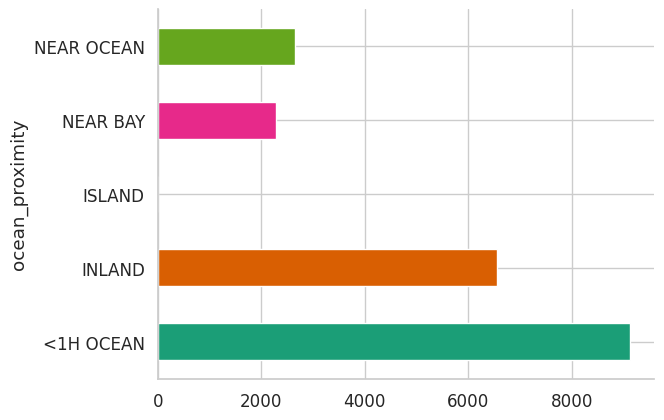

In [12]:
# ocean proximity

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('ocean_proximity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

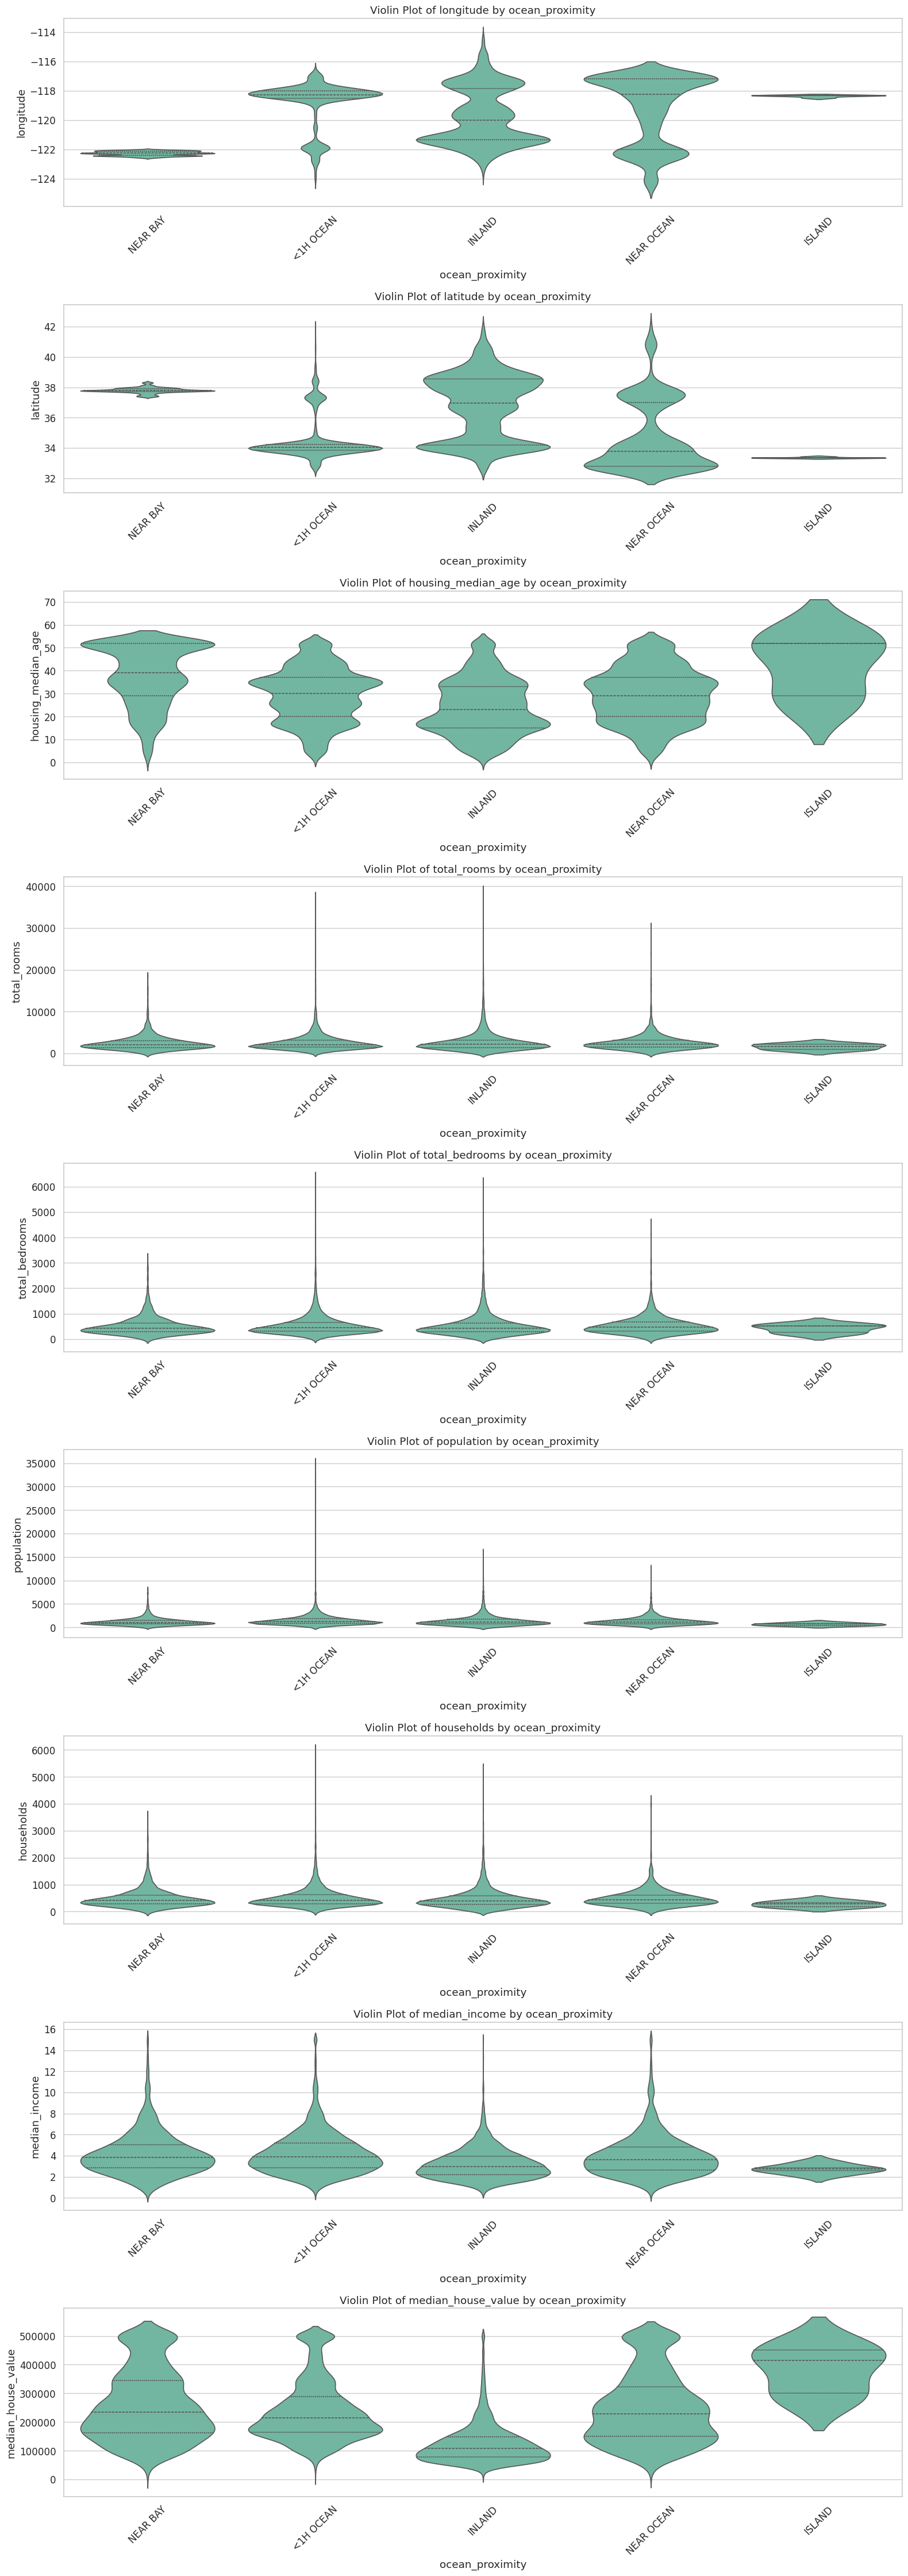

In [13]:
# Set Seaborn style
sns.set(style='whitegrid', palette='Set2', font_scale=1.1)

# Filter numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Choose a categorical column to group by
group_col = 'ocean_proximity'

# Plot violin plots for each numeric feature grouped by 'ocean_proximity'
plt.figure(figsize=(16, len(numeric_cols)*5))
for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols), 1, i+1)
    sns.violinplot(x=group_col, y=col, data=df, inner='quartile', scale='width')
    plt.title(f'Violin Plot of {col} by {group_col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Drop rows with missing target
df = df.dropna(subset=['median_house_value'])

In [15]:
# Define features and target
X = df.drop(columns=['median_house_value'])
y = df['median_house_value']

In [16]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [17]:
# Drop rows with missing values in numerical columns
X = X.dropna(subset=numerical_cols)
y = y.loc[X.index]  # Align y with X

In [18]:
# Preprocessing
preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

In [19]:
# Linear regression pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [20]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ocean_proximity'])])),
                ('regressor', LinearRegression())])

In [21]:
# Predict
y_pred = model.predict(X_test)

# Evaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:,.2f}")

R² Score: 0.6488
RMSE: 69,297.72


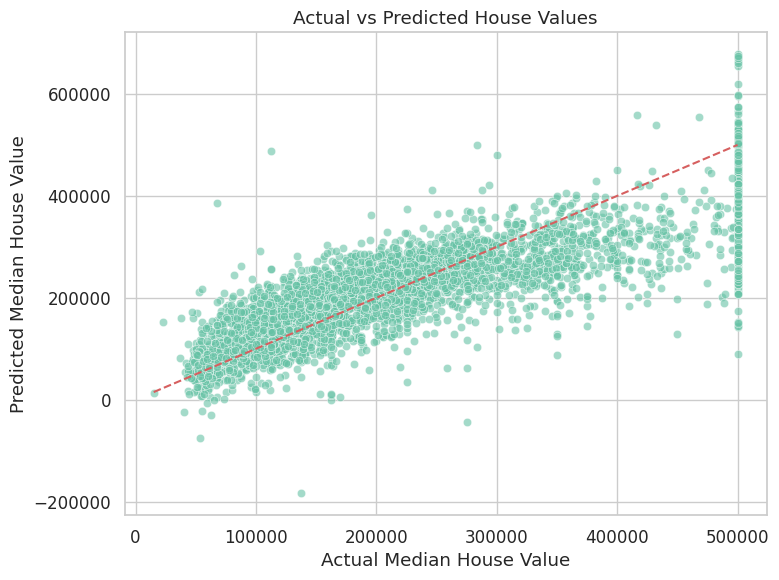

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Median House Value')
plt.ylabel('Predicted Median House Value')
plt.title('Actual vs Predicted House Values')
plt.tight_layout()
plt.show()


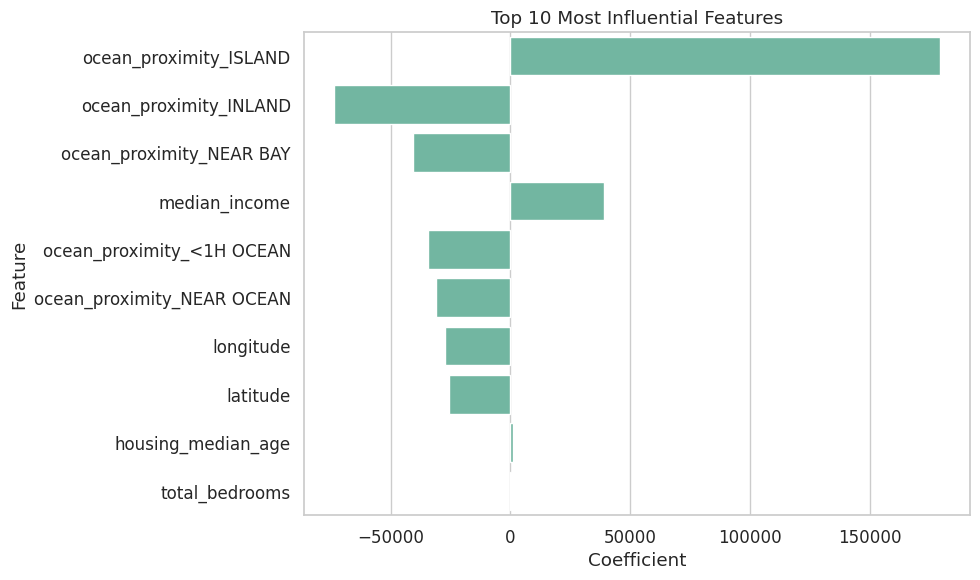

In [23]:
# Extract feature names
encoded_cat_cols = model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(encoded_cat_cols)

# Extract coefficients
coefficients = model.named_steps['regressor'].coef_

# Plot top 10 most influential features
coef_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})
top_features = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Coefficient', y='Feature')
plt.title('Top 10 Most Influential Features')
plt.tight_layout()
plt.show()


In [24]:
# Feature Engineering
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

In [25]:
# Drop NA
df = df.dropna(subset=['median_house_value'])
df = df.dropna()

In [26]:
# Feature Selection
X = df.drop(columns=['median_house_value'])
y = df['median_house_value']

In [27]:
# Feature Selection
X = df.drop(columns=['median_house_value'])
y = df['median_house_value']

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Linear Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

In [29]:
# Polynomial Regression
poly_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('regressor', LinearRegression())
])
poly_pipeline.fit(X_train, y_train)
y_pred_poly = poly_pipeline.predict(X_test)
r2_poly = r2_score(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))

In [30]:
# Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

In [31]:
# XGBoost with Grid Search
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])
param_grid = {
    'regressor__n_estimators': [100],
    'regressor__max_depth': [3, 5],
    'regressor__learning_rate': [0.05, 0.1]
}
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

In [32]:
# Model Comparison Table
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Polynomial Regression', 'Random Forest', 'XGBoost (Tuned)'],
    'R² Score': [r2_lr, r2_poly, r2_rf, r2_xgb],
    'RMSE': [rmse_lr, rmse_poly, rmse_rf, rmse_xgb]
})

print("📊 Model Comparison:\n")
print(results)

# Optional: Save to CSV
# results.to_csv("model_comparison.csv", index=False)

📊 Model Comparison:

                   Model  R² Score           RMSE
0      Linear Regression  0.651419   69042.799689
1  Polynomial Regression -0.313484  134022.899876
2          Random Forest  0.812170   50681.491084
3        XGBoost (Tuned)  0.823761   49092.799402


🔍 Interpretation of Each Model

✅ 1. Linear Regression
R² = 0.65: This model explains about 65% of the variation in housing prices.

RMSE = $69,043: On average, the model's predictions are off by about $69k.

Verdict: Not bad for a simple model, but likely underfitting due to its linear assumptions.

❌ 2. Polynomial Regression (degree=2)
R² = -0.31: A negative R² means the model performs worse than a horizontal line at the mean of y. It’s overfitting the training data and failing badly on test data.

RMSE = $134,023: Very high error.

Verdict: Polynomial features added complexity without improving generalization — this model severely overfits.

✅ 3. Random Forest
R² = 0.81: Explains 81% of the variance in the test set — a strong result.

RMSE = $50,681: Reduced error significantly from linear regression.

Verdict: Handles non-linearities and feature interactions well. Performs reliably without much tuning.

✅ 4. XGBoost (Tuned)
R² = 0.824: Best performer, explaining 82.4% of the variance.

RMSE = $49,093: Lowest error overall.

Verdict: This tuned model generalizes well and outperforms others by a small but meaningful margin. It's efficient, regularized, and robust.



🏁 Final Recommendation
Best Model: ✅ XGBoost (Tuned) — most accurate and generalizes best.

Solid Backup: ✅ Random Forest — strong performer with fewer tuning requirements.

Discard: ❌ Polynomial Regression — too complex, poor generalization.

Baseline: ✅ Linear Regression — good for interpretability, but limited power.

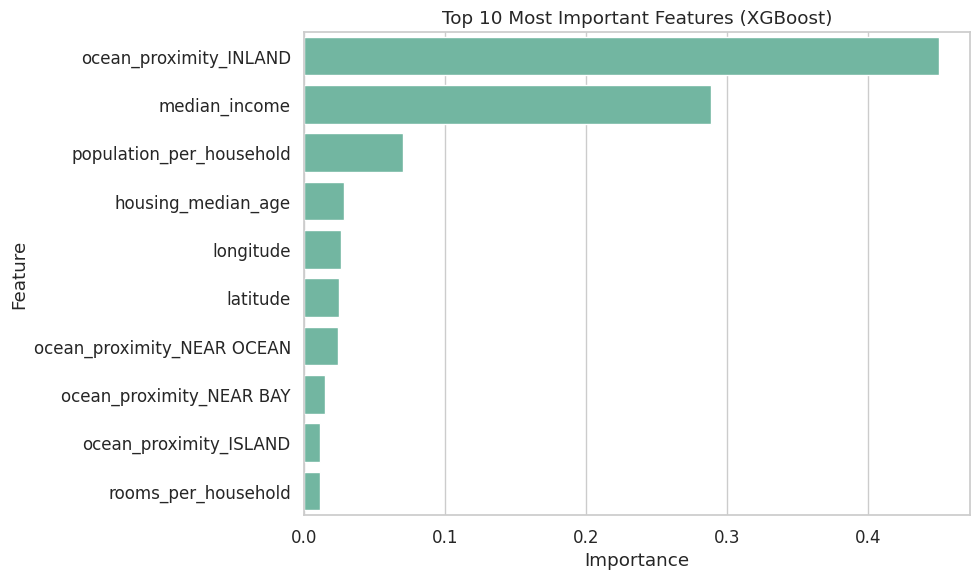

In [33]:
# Get feature names from preprocessor
encoded_cat_cols = best_xgb.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(encoded_cat_cols)

# Extract feature importances from the XGBoost regressor
importances = best_xgb.named_steps['regressor'].feature_importances_

# Create a DataFrame of features and importances
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

# Sort by importance and get top 10
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Feature')
plt.title('Top 10 Most Important Features (XGBoost)')
plt.tight_layout()
plt.show()


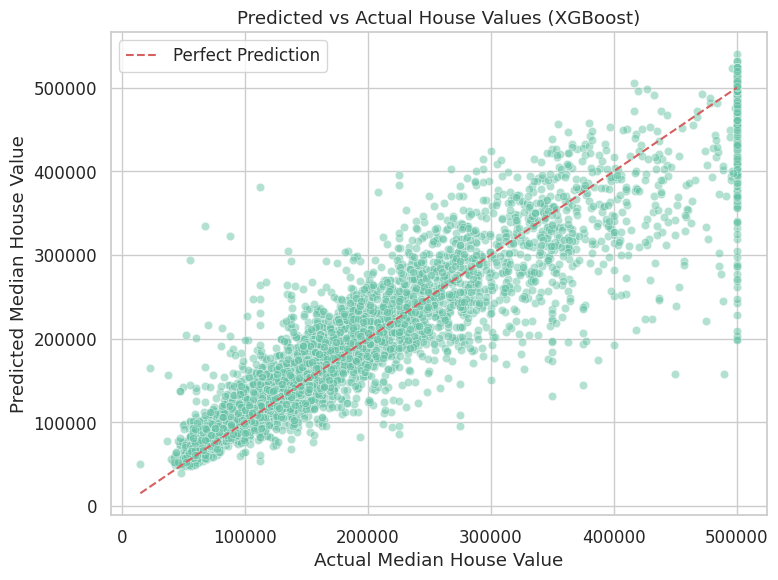

In [34]:
# Recreate X_test with engineered features
X_test_fe = X_test.copy()
X_test_fe['rooms_per_household'] = X_test_fe['total_rooms'] / X_test_fe['households']
X_test_fe['bedrooms_per_room'] = X_test_fe['total_bedrooms'] / X_test_fe['total_rooms']
X_test_fe['population_per_household'] = X_test_fe['population'] / X_test_fe['households']

# Now predict using the updated X_test_fe
y_pred = best_xgb.predict(X_test_fe)

# Plot predicted vs actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("Predicted vs Actual House Values (XGBoost)")
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
# install shap for explainable ai
!pip install shap


In [36]:
import shap

# Explain only the model, not the preprocessing pipeline
xgb_model = best_xgb.named_steps['regressor']

# Get raw feature matrix after preprocessing
X_processed = best_xgb.named_steps['preprocessor'].transform(X_test)

# Create SHAP explainer for tree-based models (like XGBoost)
explainer = shap.Explainer(xgb_model)

# Compute SHAP values
shap_values = explainer(X_processed)


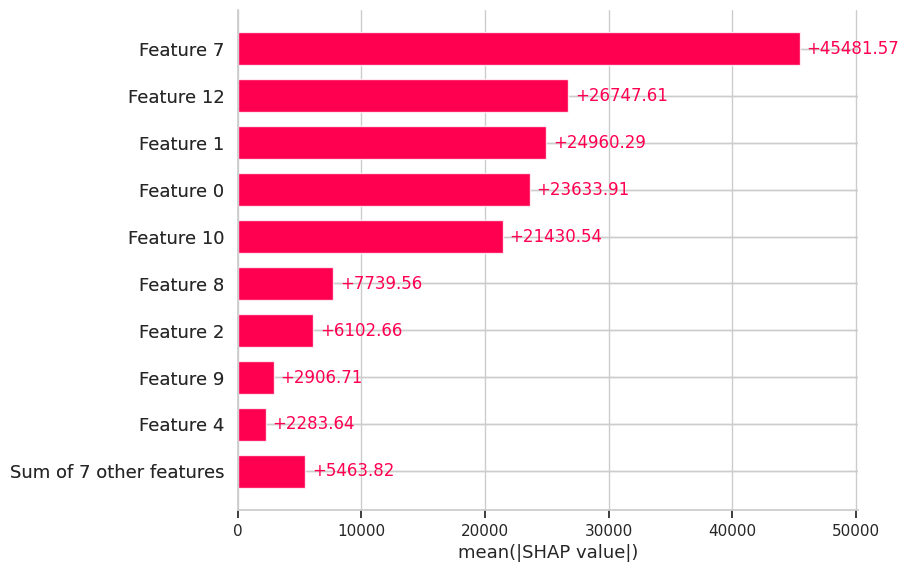

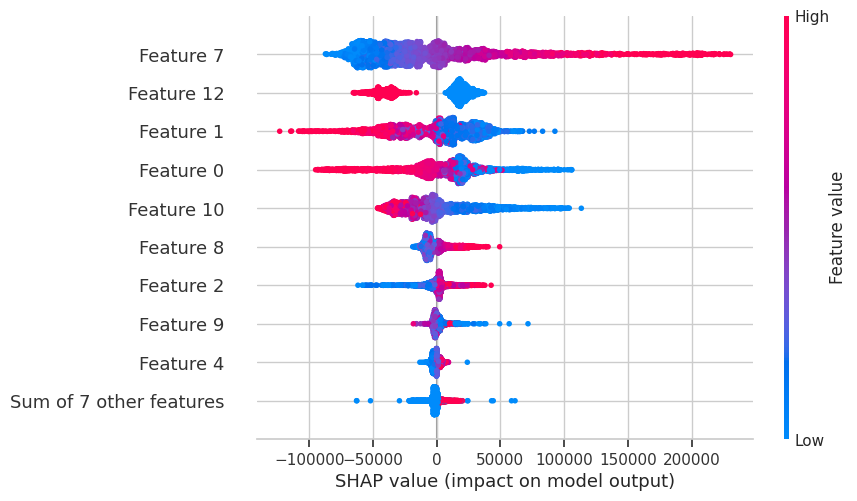

In [37]:
# Combine raw feature names
encoded_cat_cols = best_xgb.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(encoded_cat_cols)

# Convert to DataFrame for plot labeling
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names)

# SHAP summary plot (bar chart)
shap.plots.bar(shap_values, max_display=10)

# SHAP summary plot (beeswarm)
shap.plots.beeswarm(shap_values, max_display=10)


 What SHAP Tells You
Bar Plot: Feature importance globally across all predictions.

Beeswarm Plot: How each feature’s value pushes predictions higher or lower.

Waterfall Plot: Breakdown of an individual prediction’s logic.

In [38]:
# Get all feature names from preprocessing
encoded_cat_cols = best_xgb.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(encoded_cat_cols)

# Create index mapping
for i, name in enumerate(all_feature_names):
    print(f"Feature {i} → {name}")


Feature 0 → longitude
Feature 1 → latitude
Feature 2 → housing_median_age
Feature 3 → total_rooms
Feature 4 → total_bedrooms
Feature 5 → population
Feature 6 → households
Feature 7 → median_income
Feature 8 → rooms_per_household
Feature 9 → bedrooms_per_room
Feature 10 → population_per_household
Feature 11 → ocean_proximity_<1H OCEAN
Feature 12 → ocean_proximity_INLAND
Feature 13 → ocean_proximity_ISLAND
Feature 14 → ocean_proximity_NEAR BAY
Feature 15 → ocean_proximity_NEAR OCEAN


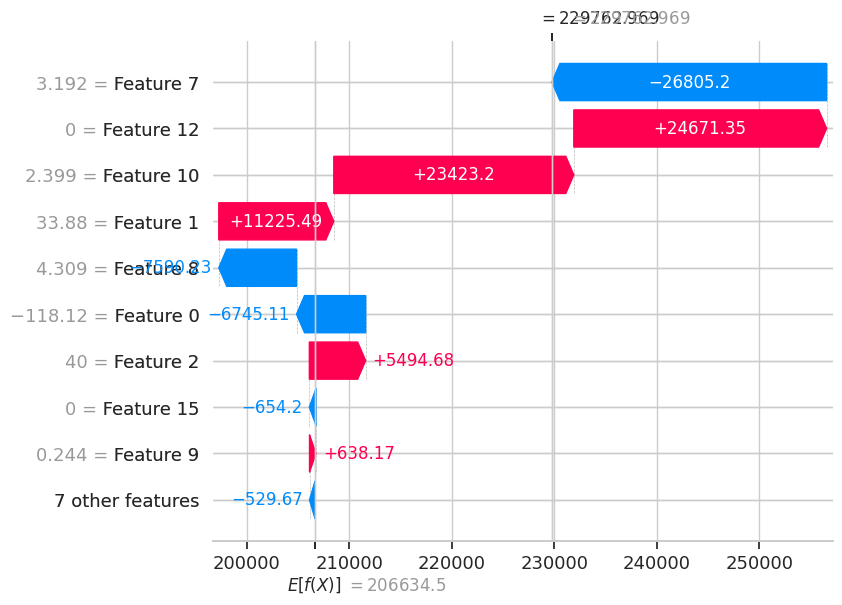

In [39]:
# Explain one specific prediction
sample_idx = 500  # change to any row
shap.plots.waterfall(shap_values[sample_idx], max_display=10)


In [40]:
pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.4 MB/s eta 0:00:00


In [41]:
import gradio as gr

# Define the function that takes raw inputs and returns the prediction
def predict_house_value(housing_median_age, total_rooms, total_bedrooms, population, households,
                        median_income, longitude, latitude, ocean_proximity):
    # Build a single-row DataFrame
    data = pd.DataFrame([{
        "housing_median_age": housing_median_age,
        "total_rooms": total_rooms,
        "total_bedrooms": total_bedrooms,
        "population": population,
        "households": households,
        "median_income": median_income,
        "longitude": longitude,
        "latitude": latitude,
        "ocean_proximity": ocean_proximity
    }])

    # Add engineered features
    data["rooms_per_household"] = data["total_rooms"] / data["households"]
    data["bedrooms_per_room"] = data["total_bedrooms"] / data["total_rooms"]
    data["population_per_household"] = data["population"] / data["households"]

    # Predict using the best model
    prediction = best_xgb.predict(data)[0]
    return f"Predicted Median House Value: ${prediction:,.2f}"


In [42]:
# Define input widgets
inputs = [
    gr.Slider(1, 52, value=20, label="Housing Median Age"),
    gr.Slider(100, 10000, step=100, value=2000, label="Total Rooms"),
    gr.Slider(50, 5000, step=50, value=400, label="Total Bedrooms"),
    gr.Slider(100, 10000, step=100, value=1500, label="Population"),
    gr.Slider(50, 2000, step=10, value=300, label="Households"),
    gr.Slider(0.5, 15, step=0.1, value=4.5, label="Median Income"),
    gr.Slider(-125, -113, step=0.1, value=-120, label="Longitude"),
    gr.Slider(32, 42, step=0.1, value=36, label="Latitude"),
    gr.Dropdown(choices=["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"], value="<1H OCEAN", label="Ocean Proximity")
]

# Output
output = gr.Textbox(label="Prediction")

# Launch the interface
gr.Interface(fn=predict_house_value, inputs=inputs, outputs=output, title="California House Value Predictor").launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e85b79a0a56ddf11a6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [43]:

# === Enhanced Feature Engineering ===
import numpy as np
from sklearn.cluster import KMeans

# Add new features
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']
df['income_per_person'] = df['median_income'] / df['population']

# Log transform skewed features
for col in ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']:
    df[f'log_{col}'] = np.log1p(df[col])

# Geographic clustering
coords = df[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=5, random_state=42)
df['geo_cluster'] = kmeans.fit_predict(coords)

# Ordinal encoding of ocean proximity
proximity_order = df.groupby('ocean_proximity')['median_house_value'].mean().sort_values().index
df['ocean_proximity_encoded'] = df['ocean_proximity'].apply(lambda x: list(proximity_order).index(x))


In [44]:

# === Updated Feature Set and Train-Test Split ===
from sklearn.model_selection import train_test_split

features = [
    'housing_median_age', 'latitude', 'longitude',
    'rooms_per_household', 'bedrooms_per_room', 'population_per_household',
    'income_per_person', 'geo_cluster', 'ocean_proximity_encoded'
] + [f'log_{col}' for col in ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']]

X = df[features]
y = df['median_house_value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [45]:

# === Retrain All Models ===
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = {"R² Score": r2, "RMSE": rmse}

# Display results
import pandas as pd
results_df = pd.DataFrame(results).T
results_df


,R² Score,RMSE
Linear Regression,0.647535,69426.361649
Random Forest,0.812692,50611.030541
XGBoost,0.836658,47262.325904


In [46]:

# === Gradio App for Predicting House Value ===
import gradio as gr

# Load best model (e.g., XGBoost from the previous training)
best_model = models["XGBoost"]

# Define prediction function
def predict_house_value(housing_median_age, latitude, longitude, total_rooms, total_bedrooms,
                        population, households, median_income, ocean_proximity):

    # Construct input record
    input_data = pd.DataFrame({
        'housing_median_age': [housing_median_age],
        'latitude': [latitude],
        'longitude': [longitude],
        'total_rooms': [total_rooms],
        'total_bedrooms': [total_bedrooms],
        'population': [population],
        'households': [households],
        'median_income': [median_income],
        'ocean_proximity': [ocean_proximity]
    })

    # Feature engineering
    input_data['rooms_per_household'] = input_data['total_rooms'] / input_data['households']
    input_data['bedrooms_per_room'] = input_data['total_bedrooms'] / input_data['total_rooms']
    input_data['population_per_household'] = input_data['population'] / input_data['households']
    input_data['income_per_person'] = input_data['median_income'] / input_data['population']

    for col in ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']:
        input_data[f'log_{col}'] = np.log1p(input_data[col])

    # Cluster label approximation (just pick the closest cluster center from training set)
    from sklearn.metrics import pairwise_distances_argmin_min
    cluster_centers = kmeans.cluster_centers_
    input_data['geo_cluster'] = pairwise_distances_argmin_min(
        input_data[['latitude', 'longitude']], cluster_centers
    )[0]

    # Ordinal encoding of ocean proximity
    input_data['ocean_proximity_encoded'] = input_data['ocean_proximity'].apply(
        lambda x: list(proximity_order).index(x)
    )

    # Final input
    input_final = input_data[features]
    prediction = best_model.predict(input_final)[0]
    return f"${prediction:,.2f}"

# Create Gradio interface
gr.Interface(
    fn=predict_house_value,
    inputs=[
        gr.Slider(1, 52, step=1, label="Housing Median Age"),
        gr.Slider(32, 42, step=0.1, label="Latitude"),
        gr.Slider(-125, -113, step=0.1, label="Longitude"),
        gr.Slider(100, 50000, step=100, label="Total Rooms"),
        gr.Slider(50, 10000, step=50, label="Total Bedrooms"),
        gr.Slider(100, 40000, step=100, label="Population"),
        gr.Slider(50, 6000, step=10, label="Households"),
        gr.Slider(0.5, 15, step=0.1, label="Median Income"),
        gr.Dropdown(choices=['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], label="Ocean Proximity")
    ],
    outputs=gr.Textbox(label="Predicted Median House Value"),
    title="California House Price Estimator (XGBoost)",
    description="Enter housing attributes to get a real-time estimate of median house value."
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://61ba31df194ad2246d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


| **Model**                 | **R² (Before)** | **RMSE (Before)** | **R² (After)** | **RMSE (After)** | **Δ R²** | **Δ RMSE** |
| ------------------------- | --------------- | ----------------- | -------------- | ---------------- | -------- | ---------- |
| **Linear Regression**     | 0.651           | \$69,043          | 0.648          | \$69,426         | ↓ 0.003  | ↑ \$383    |
| **Polynomial Regression** | ❌ -0.313        | ❌ \$134,023       | —              | —                | —        | —          |
| **Random Forest**         | 0.812           | \$50,681          | 0.813          | \$50,611         | ↑ 0.001  | ↓ \$70     |
| **XGBoost (Tuned)**       | 0.824           | \$49,093          | **0.837**      | **\$47,262**     | ↑ 0.013  | ↓ \$1,831  |


🧠 Insights
✅ XGBoost
Largest improvement: +1.3% R², ~$1.8K RMSE reduction

The model now explains nearly 84% of the variance — excellent for real estate data.

✅ Random Forest
Stable performance with marginal improvement.

Likely benefited from new features, but less sensitive to transformations than XGBoost.

⚠️ Linear Regression
Minor regression in performance.

Despite feature engineering, linearity is still too restrictive for this dataset.

❌ Polynomial Regression
Overfit the training data and crashed performance earlier — rightly discarded.

| Model                       | Status                                                               |
| --------------------------- | -------------------------------------------------------------------- |
| ✅ **XGBoost**               | Use in production (best performance, scalable, explainable via SHAP) |
| ✅ **Random Forest**         | Good backup (robust, minimal tuning needed)                          |
| ❌ **Polynomial Regression** | Discard (poor generalization)                                        |
| ⚠️ **Linear Regression**    | Use for interpretability only                                        |


In [54]:
# Assuming df is your full housing DataFrame

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Basic feature engineering
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['population_per_household'] = df['population'] / df['households']

features = ['median_income', 'rooms_per_household', 'population_per_household', 'latitude', 'longitude']
X = df[features]
y = df['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Save it
model.save_model("model.json")


In [57]:
# Load full dataset
df_full = pd.read_csv("housing/housing.csv")

# Create a 500-row sample
df_sample = df_full.sample(n=500, random_state=42)

# Save it
df_sample.to_csv("housing_sample.csv", index=False)


In [60]:
# 📦 Install lightweight dependencies
!pip install -q transformers gradio shap xgboost pandas scikit-learn

# 🔁 Imports
import gradio as gr
import xgboost as xgb
import pandas as pd
import numpy as np
import shap
from transformers import pipeline, set_seed

# Load your trained XGBoost model
model = xgb.XGBRegressor()
model.load_model("model.json")  # Ensure this file is uploaded

# Load sample dataset
df = pd.read_csv("housing_sample.csv")  # Upload this CSV as a 500-row slice

# Load lightweight Hugging Face models
generator = pipeline("text-generation", model="distilgpt2")
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

# Set seed for consistent output
set_seed(42)

# Predict and Explain
def predict_and_explain(user_query, median_income=4, rooms_per_household=5, population_per_household=3, latitude=36, longitude=-120):
    input_data = pd.DataFrame([{
        "median_income": median_income,
        "rooms_per_household": rooms_per_household,
        "population_per_household": population_per_household,
        "latitude": latitude,
        "longitude": longitude
    }])
    prediction = model.predict(input_data)[0]

    # SHAP Explanation
    explainer = shap.Explainer(model)
    shap_values = explainer(input_data)
    top_idx = np.argsort(np.abs(shap_values.values[0]))[::-1][:3]
    top_features = input_data.columns[top_idx]
    top_imp = [f"{col}: {shap_values.values[0][i]:.2f}" for i, col in zip(top_idx, top_features)]

    # Prompt for lightweight generator
    prompt = (
        f"User asked: {user_query}. "
        f"The predicted house price is ${prediction:,.0f}. "
        f"Top features: {', '.join(top_imp)}. "
        f"Explain the result simply."
    )
    result = generator(prompt, max_new_tokens=100, do_sample=True)[0]['generated_text']
    return f"${prediction:,.0f}", result.replace(prompt, "").strip()

# Dataset Summary
def generate_summary():
    context = (
        f"This dataset includes:\n"
        f"- Median income: {df['median_income'].min()} to {df['median_income'].max()}\n"
        f"- Avg rooms/household: {df['total_rooms'].mean() / df['households'].mean():.2f}\n"
        f"- Most common ocean proximity: {df['ocean_proximity'].mode()[0]}\n"
        f"- Avg house value: ${df['median_house_value'].mean():,.0f}\n"
        f"- Latitude range: {df['latitude'].min()} to {df['latitude'].max()}\n"
        f"- Longitude range: {df['longitude'].min()} to {df['longitude'].max()}"
    )
    summary = summarizer(context, max_length=150, min_length=30, do_sample=False)
    return summary[0]['summary_text']

# 🎨 Gradio Interface
with gr.Blocks() as demo:
    gr.Markdown("## 🏡 Housing Price Chatbot (Lightweight LLM + SHAP)")

    with gr.Tab("💬 Explain Prediction (Chat Mode)"):
        gr.Markdown("### 🧠 Ask a Question and Get an LLM Explanation")

        chatbot = gr.Chatbot(label="Conversation")
        msg = gr.Textbox(label="Ask something like 'Why is the price high?'", placeholder="Enter your question...")
        history_state = gr.State([])

        # Inputs for prediction context
        median_income = gr.Slider(0, 15, value=4, label="Median Income")
        rooms_per_household = gr.Slider(1, 10, value=5, label="Rooms per Household")
        population_per_household = gr.Slider(1, 10, value=3, label="Population per Household")
        latitude = gr.Slider(32, 42, value=36, label="Latitude")
        longitude = gr.Slider(-125, -113, value=-120, label="Longitude")

        def chat_response(user_input, history, median_income, rooms_per_household, population_per_household, latitude, longitude):
            input_data = pd.DataFrame([{
                "median_income": median_income,
                "rooms_per_household": rooms_per_household,
                "population_per_household": population_per_household,
                "latitude": latitude,
                "longitude": longitude
            }])
            prediction = model.predict(input_data)[0]

            # SHAP explanation
            explainer = shap.Explainer(model)
            shap_values = explainer(input_data)
            top_idx = np.argsort(np.abs(shap_values.values[0]))[::-1][:3]
            top_features = input_data.columns[top_idx]
            top_imp = [f"{col}: {shap_values.values[0][i]:.2f}" for i, col in zip(top_idx, top_features)]

            prompt = (
                f"Prediction context:\n"
                f"- Predicted value: ${prediction:,.0f}\n"
                f"- Influential features: {', '.join(top_imp)}\n"
                f"User asked: {user_input}\n"
                f"Answer this simply and clearly:"
            )

            response = generator(prompt, max_new_tokens=100, do_sample=True)[0]['generated_text']
            reply = response.replace(prompt, "").strip()
            history.append((user_input, reply))
            return history, history

        msg.submit(
            chat_response,
            inputs=[msg, history_state, median_income, rooms_per_household, population_per_household, latitude, longitude],
            outputs=[chatbot, history_state]
        )

    with gr.Tab("📊 Data Summary"):
        summary_btn = gr.Button("Generate Summary")
        summary_out = gr.Textbox(label="LLM Summary")
        summary_btn.click(generate_summary, outputs=summary_out)

demo.launch()


Device set to use cpu
Device set to use cpu


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bfe50ebf51d72ebb3f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
